<a href="https://colab.research.google.com/github/cbachen1997/CAUstudy/blob/Keras_TripletLoss/Keras_tripletloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#挂载谷歌云盘
from google.colab import drive
drive.mount('/content/gdrive')
####google云盘授权#####
##每个notebook执行一次###
__author__='CBA'
from google.colab import drive

#增加PyDrive操作库
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#授权登录
auth.authenticate_user()
gauth=GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)

In [ ]:
#更改运行目录
import os
os.chdir("/content/gdrive/My Drive/AndrewNgTest/Keras_tripletloss")
print (os.path.abspath('.')) #获取当前工作目录路径
print(os.listdir('.'))

/content/gdrive/My Drive/AndrewNgTest/Keras_tripletloss
['Keras_tripletloss.ipynb', 'inception_blocks_v2.py', 'fr_utils.py', '__pycache__', 'FRmodel.png', 'images', 'weights']


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K

#模型绘制
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#数据格式(m,c,w,h)
K.set_image_data_format('channels_first')

import time
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import fr_utils
from inception_blocks_v2 import *

%matplotlib inline 
#plot后直接画图，不用再show
%load_ext autoreload
#自动装入所有模块
%autoreload 2
#每运行一个cell都会重新import所有module
np.set_printoptions(threshold=1000000)#np.nan输出所有的值，不要省略号，报错未知

In [ ]:
#调用inception-v1
#inception_blocks_v2
FRmodel = faceRecoModel(input_shape=(3,96,96))
#输入(m,3,96,96)
#输出(m,128)向量
#打印模型的总参数数量
print("参数数量：" + str(FRmodel.count_params()))

参数数量：3743280


In [ ]:
#绘制模型
# %matplotlib inline
# plot_model(FRmodel, to_file='FRmodel.png',show_shapes=True)

In [ ]:
def triplet_loss(y_ture,y_pred,alpha):
  """ 
  参数：
      y_true -- true标签，当你在Keras里定义了一个损失函数的时候需要它，但是这里不需要。
      y_pred -- 列表类型，包含了如下参数：
          anchor -- 给定的“anchor”图像的编码，维度为(None,128)
          positive -- “positive”图像的编码，维度为(None,128)
          negative -- “negative”图像的编码，维度为(None,128)
      alpha -- 超参数，阈值
  
  返回：
      loss -- 实数，损失的值
  """
  #获取anchor, positive, negative的图像编码
  anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
  #第一步：计算"anchor" 与 "positive"之间编码的距离，这里需要使用axis=-1
  pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)#二范数，-1代表倒数第一个维度即128
  #第二步：计算"anchor" 与 "negative"之间编码的距离，这里需要使用axis=-1
  neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
  #第三步：减去之前的两个距离，然后加上alpha
  basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
  #通过取带零的最大值和对训练样本的求和来计算整个公式
  loss = tf.reduce_sum(tf.maximum(basic_loss,0))

  return loss


In [ ]:
#开始时间
tic = time.clock()

#编译模型
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

#加载权值
fr_utils.load_weights_from_FaceNet(FRmodel)

#结束时间
toc = time.clock()

#计算时差
minium = toc-tic

print("执行了：" + str(int(minium / 60)) + "分" + str(int(minium%60)) + "秒")

In [ ]:
database = {}
database["danielle"] = fr_utils.img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = fr_utils.img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = fr_utils.img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = fr_utils.img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = fr_utils.img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = fr_utils.img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = fr_utils.img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = fr_utils.img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = fr_utils.img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = fr_utils.img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = fr_utils.img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = fr_utils.img_to_encoding("images/arnaud.jpg", FRmodel)

In [ ]:
def verify(image_path, identity, database, model):
    """
    对“identity”与“image_path”的编码进行验证。
    
    参数：
        image_path -- 摄像头的图片。
        identity -- 字符类型，想要验证的人的名字。
        database -- 字典类型，包含了成员的名字信息与对应的编码。
        model -- 在Keras的模型的实例。
        
    返回：
        dist -- 摄像头的图片与数据库中的图片的编码的差距。
        is_open_door -- boolean,是否该开门。
    """
    #第一步：计算图像的编码，使用fr_utils.img_to_encoding()来计算。
    encoding = fr_utils.img_to_encoding(image_path, model)
    
    #第二步：计算与数据库中保存的编码的差距
    dist = np.linalg.norm(encoding - database[identity],ord=2)
    
    #第三步：判断是否打开门
    if dist < 0.5:
        print("欢迎 " + str(identity) + "回家！")
        is_door_open = True
    else:
        print("经验证，您与" + str(identity) + "不符！")
        is_door_open = False
    
    return dist, is_door_open

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
verify("images/camera_0.jpg","younes",database,FRmodel)


经验证，您与younes不符！


(0.6710065, False)

In [ ]:
def who_is_it(image_path, database,model):
    """
    根据指定的图片来进行人脸识别
    
    参数：
        images_path -- 图像地址
        database -- 包含了名字与编码的字典
        model -- 在Keras中的模型的实例。
        
    返回：
        min_dist -- 在数据库中与指定图像最相近的编码。
        identity -- 字符串类型，与min_dist编码相对应的名字。
    """
    #步骤1：计算指定图像的编码，使用fr_utils.img_to_encoding()来计算。
    encoding = fr_utils.img_to_encoding(image_path, model)
    
    #步骤2 ：找到最相近的编码
    ## 初始化min_dist变量为足够大的数字，这里设置为100
    min_dist = 100
    
    ## 遍历数据库找到最相近的编码
    for (name,db_enc) in database.items():
        ### 计算目标编码与当前数据库编码之间的L2差距。
        dist = np.linalg.norm(encoding - db_enc,ord=2)
        
        ### 如果差距小于min_dist，那么就更新名字与编码到identity与min_dist中。
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    # 判断是否在数据库中
    if min_dist > 0.5:
        print("抱歉，您的信息不在数据库中。")
        
    else:
        print('识别成功')
        print("姓名:" + str(identity) + "  差距：" + str(min_dist))
    img=Image.open(image_path)
    plt.imshow(img)
    return min_dist, identity

识别成功
姓名:bertrand  差距：0.46740162


(0.46740162, 'bertrand')

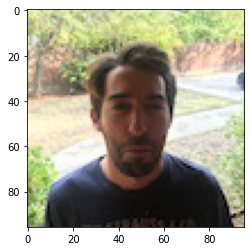

In [ ]:
who_is_it("images/camera_1.jpg", database, FRmodel)